In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'en'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese'

In [4]:
# Parameters
model_size = "13b"
target_lang = "en"
input_lang = "zh"
type = "logit"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=5120, out_features=32000, bias=False)
)
U torch.Size([32000, 5120]) weights torch.Size([1, 5120])


0.11461826413869858


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input['word_original'] = chinese['word_translation']
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese=chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input['word_original'] = chinese['word_translation']

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for en 132 of 132 are single tokens
final length of df_en_en_zh: 132


In [8]:
df_en_target_input

,lang_en,en,en_tgt,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error,lang_zh,zh,blank_prompt_original_zh,blank_prompt_translation_zh,blank_prompt_translation_masked_zh
0,en,book,book,"A ""book"" is used to read stories. Answer: ""book"".","A ""book"" is used to read stories. Answer: ""book"".","A ""___"" is used to read stories. Answer: ""book"".",no error,zh,书,"A ""book"" is used to read stories. Answer: ""book"".","""书""用来阅读故事。答案：""书""。","""_""用来阅读故事。答案：""书""。"
1,en,cloud,cloud,"A ""cloud"" is a visible mass of condensed water...","A ""cloud"" is a visible mass of condensed water...","A ""___"" is a visible mass of condensed water v...",no error,zh,云,"A ""cloud"" is a visible mass of condensed water...","""云""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。","""_""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。"
2,en,bag,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error,zh,包,"A ""bag"" is used to carry items. Answer: ""bag"".","""包""用来携带物品。答案：""包""。","""_""用来携带物品。答案：""包""。"
3,en,mouth,mouth,"A ""mouth"" is used to eat food and speak. Answe...","A ""mouth"" is used to eat food and speak. Answe...","A ""___"" is used to eat food and speak. Answer:...",no error,zh,口,"A ""mouth"" is used to eat food and speak. Answe...","""口""用来吃食物和说话。答案：""口""。","""_""用来吃食物和说话。答案：""口""。"
4,en,soil,soil,"""A ""soil"" is used for planting trees and crops...","""A ""soil"" is used for planting trees and crops...","""A ""___"" is used for planting trees and crops....",no error,zh,土,"""A ""soil"" is used for planting trees and crops...","""土""用于种植树木和作物。答案：""土""。","""_""用于种植树木和作物。答案：""土""。"
...,...,...,...,...,...,...,...,...,...,...,...,...
127,en,rise,rise,"""A ""rise"" is used to describe an increase or u...","""A ""rise"" is used to describe an increase or u...","""A ""___"" is used to describe an increase or up...",no error,zh,起,"""A ""rise"" is used to describe an increase or u...","""起""用来描述增加或向上移动。答案：""起""。","""_""用来描述增加或向上移动。答案：""起""。"
128,en,left,left,"'A ""left"" is a direction opposite to right. An...","'A ""left"" is a direction opposite to right. An...","'A ""___"" is a direction opposite to right. Ans...",no error,zh,左,"'A ""left"" is a direction opposite to right. An...","""左""是右的相反方向。答案：""左""。","""_""是右的相反方向。答案：""左""。"
129,en,sound,sound,"A ""sound"" is something we hear. Answer: ""sound"".","A ""sound"" is something we hear. Answer: ""sound"".","A ""___"" is something we hear. Answer: ""sound"".",no error,zh,音,"A ""sound"" is something we hear. Answer: ""sound"".","""音""是我们听到的东西。答案：""音""。","""_""是我们听到的东西。答案：""音""。"
130,en,power,power,"""A ""power"" is used to control or influence peo...","""A ""power"" is used to control or influence peo...","""A ""___"" is used to control or influence peopl...",no error,zh,力,"""A ""power"" is used to control or influence peo...","""力""用来控制或影响人或物。答案：""力""。","""_""用来控制或影响人或物。答案：""力""。"


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            print(intersection)
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
latent

'en'

In [12]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/132 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                                                                             | 1/132 [00:00<00:23,  5.51it/s]

{833, 29890, 289, 3143, 1045, 2909}


  2%|███▏                                                                                                                                                                                                           | 2/132 [00:00<00:27,  4.66it/s]

  2%|████▋                                                                                                                                                                                                          | 3/132 [00:00<00:23,  5.41it/s]

{17184, 9570, 23642, 1067, 274, 15126, 695, 9274, 29883}
{289, 29890, 9922, 2291, 23156, 19548}


  3%|██████▎                                                                                                                                                                                                        | 4/132 [00:00<00:25,  5.11it/s]

  4%|███████▊                                                                                                                                                                                                       | 5/132 [00:00<00:23,  5.37it/s]

{29442, 21026, 2730, 13394, 4346, 29885, 286}
{577, 578, 22473, 269, 29879}


  5%|█████████▍                                                                                                                                                                                                     | 6/132 [00:01<00:28,  4.48it/s]

{29442, 5766, 2730, 14378, 4346, 16476, 29885, 286}


  5%|██████████▉                                                                                                                                                                                                    | 7/132 [00:01<00:27,  4.56it/s]

{17184, 1067, 274, 15126, 695, 29883, 13950}


  6%|████████████▌                                                                                                                                                                                                  | 8/132 [00:01<00:27,  4.54it/s]

{354, 8293, 5192, 298, 23057, 29882, 540}


  7%|██████████████                                                                                                                                                                                                 | 9/132 [00:01<00:26,  4.63it/s]

  8%|███████████████▌                                                                                                                                                                                              | 10/132 [00:02<00:24,  5.06it/s]

{298, 3179, 2350, 1361, 5905, 29882, 5403, 447}
{1388, 270, 3250, 29881, 1146, 2462}


  8%|█████████████████▏                                                                                                                                                                                            | 11/132 [00:02<00:24,  5.00it/s]

{269, 303, 5810, 9523, 5173, 29879, 380, 8508}


  9%|██████████████████▋                                                                                                                                                                                           | 12/132 [00:02<00:25,  4.62it/s]

 10%|████████████████████▎                                                                                                                                                                                         | 13/132 [00:02<00:23,  4.97it/s]

{1028, 805, 7689, 269, 6709, 4278, 29879, 15099}
{18786, 2730, 4346, 29885, 286}


 11%|█████████████████████▊                                                                                                                                                                                        | 14/132 [00:02<00:22,  5.14it/s]

{6115, 29893, 8879, 8112, 281, 827}


 11%|███████████████████████▍                                                                                                                                                                                      | 15/132 [00:03<00:26,  4.35it/s]

{325, 29894, 17191, 21031, 11928, 4213, 5720, 1403, 3516, 28765}


 12%|████████████████████████▉                                                                                                                                                                                     | 16/132 [00:03<00:28,  4.14it/s]

 13%|██████████████████████████▌                                                                                                                                                                                   | 17/132 [00:03<00:26,  4.42it/s]

{29888, 13569, 1701, 363, 1454, 1181, 1079, 26839, 285}
{29888, 1424, 1341, 285, 15774}


 14%|████████████████████████████                                                                                                                                                                                  | 18/132 [00:03<00:24,  4.68it/s]

{867, 6856, 7720, 330, 629, 29887}
{577, 578, 1100, 269, 21453, 1487, 4823, 29879}


 14%|█████████████████████████████▋                                                                                                                                                                                | 19/132 [00:04<00:23,  4.75it/s]

 15%|███████████████████████████████▏                                                                                                                                                                              | 20/132 [00:04<00:23,  4.70it/s]

 16%|████████████████████████████████▊                                                                                                                                                                             | 21/132 [00:04<00:22,  4.84it/s]

{29893, 2766, 281, 16699, 11324, 13405, 4094}
{2818, 772, 1129, 1112, 282, 12509, 29886}


 17%|██████████████████████████████████▎                                                                                                                                                                           | 22/132 [00:04<00:22,  4.91it/s]

{28455, 872, 269, 11982, 4977, 29879, 9753}


 17%|███████████████████████████████████▉                                                                                                                                                                          | 23/132 [00:04<00:23,  4.66it/s]

 18%|█████████████████████████████████████▍                                                                                                                                                                        | 24/132 [00:05<00:21,  5.12it/s]

{8580, 364, 4401, 374, 3511, 29878, 9050, 10107, 1150}
{425, 301, 433, 4307, 29880, 10653}


 19%|███████████████████████████████████████                                                                                                                                                                       | 25/132 [00:05<00:20,  5.28it/s]

{29893, 2766, 10742, 27766, 281, 11324}


 20%|████████████████████████████████████████▌                                                                                                                                                                     | 26/132 [00:05<00:20,  5.14it/s]

 20%|██████████████████████████████████████████▏                                                                                                                                                                   | 27/132 [00:05<00:19,  5.29it/s]

{288, 25802, 23474, 29877, 12954, 542}
{24230, 18346, 5777, 274, 1113, 29883}


 21%|███████████████████████████████████████████▋                                                                                                                                                                  | 28/132 [00:05<00:18,  5.75it/s]

 22%|█████████████████████████████████████████████▎                                                                                                                                                                | 29/132 [00:05<00:18,  5.61it/s]

{7205, 269, 29879, 344, 409}
{425, 19437, 301, 24591, 433, 29880, 18170}


 23%|██████████████████████████████████████████████▊                                                                                                                                                               | 30/132 [00:06<00:20,  5.05it/s]

{2752, 577, 578, 4993, 269, 3669, 29879}
{29888, 28034, 3974, 13734, 7241, 5713, 8696, 285}


 23%|████████████████████████████████████████████████▍                                                                                                                                                             | 31/132 [00:06<00:20,  5.03it/s]

 24%|█████████████████████████████████████████████████▉                                                                                                                                                            | 32/132 [00:06<00:20,  4.92it/s]

{772, 1129, 3149, 1298, 282, 11899, 29886}


 25%|███████████████████████████████████████████████████▌                                                                                                                                                          | 33/132 [00:06<00:23,  4.28it/s]

{325, 29894, 1224, 874, 3259, 1873, 369, 2453, 345, 1147}
{289, 29890, 9922, 6411, 5521, 2291, 2135, 8287}


 26%|█████████████████████████████████████████████████████                                                                                                                                                         | 34/132 [00:07<00:21,  4.46it/s]

 27%|██████████████████████████████████████████████████████▌                                                                                                                                                       | 35/132 [00:07<00:23,  4.10it/s]

{6788, 3300, 3274, 10675, 282, 20413, 29886}


 27%|████████████████████████████████████████████████████████▏                                                                                                                                                     | 36/132 [00:07<00:25,  3.75it/s]

{6112, 1002, 23436, 269, 303, 19569, 5073, 9523, 5173, 29879, 380}


 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                    | 37/132 [00:07<00:23,  4.02it/s]

 29%|███████████████████████████████████████████████████████████▎                                                                                                                                                  | 38/132 [00:08<00:20,  4.53it/s]

{364, 19408, 29878, 374, 2200, 11674, 10107, 9597}
{1127, 364, 337, 276, 29878, 2654}


 30%|████████████████████████████████████████████████████████████▊                                                                                                                                                 | 39/132 [00:08<00:20,  4.63it/s]

 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                               | 40/132 [00:08<00:18,  5.08it/s]

{1220, 6276, 619, 492, 301, 1196, 29880, 1915}
{452, 484, 7787, 302, 29876, 1212}


 31%|███████████████████████████████████████████████████████████████▉                                                                                                                                              | 41/132 [00:08<00:19,  4.63it/s]

 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                            | 42/132 [00:08<00:17,  5.18it/s]

{29888, 1731, 1579, 4972, 1652, 28149, 5685, 285}
{260, 23429, 29873, 371, 734}


 33%|███████████████████████████████████████████████████████████████████                                                                                                                                           | 43/132 [00:08<00:17,  5.11it/s]

 33%|████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 44/132 [00:09<00:16,  5.27it/s]

{29888, 6661, 1701, 3661, 7953, 1181, 5431, 285}
{7684, 330, 1484, 748, 15192, 29887}


 34%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 45/132 [00:09<00:16,  5.36it/s]

 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 46/132 [00:09<00:15,  5.56it/s]

{3050, 1867, 270, 437, 29881, 17433}
{16586, 269, 5807, 29879, 15007}


 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 47/132 [00:09<00:16,  5.15it/s]

 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 48/132 [00:09<00:15,  5.51it/s]

{5089, 1251, 10435, 2015, 298, 29882, 4029, 11231}
{288, 265, 650, 373, 29877, 697}


 37%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 49/132 [00:10<00:14,  5.78it/s]

{260, 10184, 29873, 3252, 7516, 1023}


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                | 50/132 [00:10<00:15,  5.29it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 51/132 [00:10<00:15,  5.29it/s]

{17536, 386, 2211, 260, 12455, 266, 29873, 1468}
{29888, 1701, 12584, 3023, 1181, 285, 17823}


 39%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 52/132 [00:10<00:14,  5.37it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 53/132 [00:10<00:13,  5.69it/s]

{29888, 5320, 7241, 5713, 20818, 285}
{4832, 1354, 269, 1039, 29879, 28319}


 41%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 54/132 [00:10<00:14,  5.55it/s]

{409, 269, 29879, 344, 9881}
{321, 9475, 29319, 29872, 15761, 10096}


 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 55/132 [00:11<00:14,  5.34it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 56/132 [00:11<00:14,  5.42it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 57/132 [00:11<00:13,  5.72it/s]

{14183, 302, 29876, 6836, 1240, 17081}
{260, 841, 29873, 371, 3006, 734}


 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 58/132 [00:11<00:12,  5.70it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 59/132 [00:11<00:13,  5.55it/s]

{354, 2343, 298, 29882, 540, 2813}
{19032, 845, 269, 528, 17394, 29879, 18296}


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 60/132 [00:12<00:14,  5.02it/s]

{710, 269, 303, 17010, 851, 29879, 380, 17820, 10076}


 46%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 61/132 [00:12<00:15,  4.47it/s]

{710, 29352, 269, 303, 11952, 12243, 851, 13045, 29879, 380}
{610, 3300, 3274, 862, 760, 282, 1595, 29886}


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 62/132 [00:12<00:15,  4.59it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 63/132 [00:12<00:13,  5.23it/s]

{29872, 1032, 10977, 321}


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 64/132 [00:12<00:13,  5.05it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 65/132 [00:13<00:13,  5.12it/s]

{29888, 29607, 7241, 2671, 5713, 1746, 285}
{3268, 7845, 1354, 269, 1039, 29879, 2746}


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 66/132 [00:13<00:13,  4.97it/s]

{6025, 1388, 270, 18386, 29881, 1146, 17948}
{13762, 29893, 1734, 1742, 8879, 281, 827, 6365}


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 67/132 [00:13<00:13,  4.97it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 68/132 [00:13<00:12,  5.15it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 69/132 [00:13<00:11,  5.30it/s]

{18784, 3300, 3274, 5101, 282, 29886}
{7205, 269, 12949, 29879, 344, 409}


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 70/132 [00:14<00:12,  4.98it/s]

{619, 492, 301, 4366, 3473, 29880, 3578, 14172}


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 71/132 [00:14<00:13,  4.40it/s]

{386, 260, 10405, 266, 7693, 29873, 12595}


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 72/132 [00:14<00:13,  4.49it/s]

{1217, 15459, 302, 6641, 29876, 694, 3643}


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 73/132 [00:14<00:14,  4.12it/s]

{5825, 611, 23523, 4933, 655, 8628, 7672, 29885, 286}
{9346, 931, 260, 29873, 19538, 2034, 2230, 5335}


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 74/132 [00:15<00:13,  4.34it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 75/132 [00:15<00:14,  4.03it/s]

{289, 29890, 367, 3856, 7795, 915, 14169, 1785, 13982}


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 76/132 [00:15<00:15,  3.71it/s]

{772, 1129, 2602, 1066, 3283, 926, 13686, 282, 29886}


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 77/132 [00:16<00:15,  3.48it/s]

{544, 8482, 771, 12291, 282, 1326, 558, 410, 16123, 29886}


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 78/132 [00:16<00:15,  3.47it/s]

{321, 429, 6543, 29872, 14523, 5566, 735}


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 79/132 [00:16<00:14,  3.60it/s]

{6563, 7145, 7256, 3737, 2460, 29885, 17662, 286}


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 80/132 [00:16<00:14,  3.69it/s]

{29888, 5121, 7932, 1424, 18326, 1341, 3484, 285}


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 81/132 [00:17<00:13,  3.83it/s]

{2927, 784, 274, 10965, 1302, 1111, 29883, 2780, 1054}
{1984, 9089, 19015, 29895, 2924, 14380, 8506, 413}


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 82/132 [00:17<00:12,  4.11it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 83/132 [00:17<00:11,  4.25it/s]

{16833, 4900, 29926, 3623, 17675, 432, 6577}


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 84/132 [00:17<00:11,  4.15it/s]

{27041, 269, 816, 3762, 1364, 885, 1557, 29879}


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 85/132 [00:18<00:13,  3.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 86/132 [00:18<00:11,  4.17it/s]

{23905, 710, 2281, 6220, 269, 303, 851, 3829, 10582, 29879, 4984, 380}
{260, 29873, 19538, 2034, 22134}


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 87/132 [00:18<00:11,  4.04it/s]

{321, 4773, 4392, 429, 29872, 1342, 735}
{29888, 5444, 2161, 2258, 3700, 4024, 285, 17470}


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 88/132 [00:18<00:10,  4.26it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 89/132 [00:19<00:10,  4.16it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 90/132 [00:19<00:09,  4.43it/s]

{289, 29890, 1506, 19515, 12945, 18419, 28635, 1182}
{2944, 29875, 372, 277, 568, 474, 667}


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 91/132 [00:19<00:09,  4.19it/s]

{6144, 5217, 7374, 270, 8143, 628, 311, 29881, 316}


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 92/132 [00:19<00:09,  4.25it/s]

{867, 4071, 330, 2318, 17170, 629, 2972, 29887}


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 93/132 [00:19<00:09,  4.15it/s]

{260, 941, 5969, 29873, 24242, 11062, 20411, 17694}


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 94/132 [00:20<00:09,  4.21it/s]

{289, 6562, 29890, 367, 15409, 915}


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 95/132 [00:20<00:09,  3.82it/s]

{2174, 715, 18870, 13974, 12120, 7481, 282, 572, 29886}


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 96/132 [00:20<00:09,  3.98it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 97/132 [00:20<00:07,  4.51it/s]

{5089, 1251, 298, 9261, 3699, 10774, 8697, 29882}
{480, 2146, 269, 6575, 11445, 29879}


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 98/132 [00:21<00:07,  4.26it/s]

{11781, 17897, 1004, 5870, 592, 29885, 286}


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 99/132 [00:21<00:08,  3.87it/s]

{22880, 9825, 18434, 2918, 298, 7251, 16211, 3603, 29882, 4955, 670}


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 100/132 [00:21<00:08,  3.83it/s]

{2947, 325, 29894, 28519, 19599, 659, 791, 22044, 1564}


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 101/132 [00:21<00:08,  3.83it/s]

{3044, 269, 6862, 10674, 17619, 26613, 29879, 18074}


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 102/132 [00:22<00:08,  3.36it/s]

{4738, 2531, 18530, 1737, 330, 479, 12623, 1176, 1885, 29887}


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/132 [00:22<00:07,  3.66it/s]

{577, 578, 269, 13267, 3669, 7062, 29879}


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 104/132 [00:22<00:07,  3.69it/s]

{4610, 325, 2405, 29894, 10636, 1403, 3516, 15389, 27935}


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 105/132 [00:23<00:06,  3.87it/s]

{260, 3367, 3626, 29873, 534, 9434, 29563, 509}
{455, 4583, 4272, 7537, 274, 12690, 20752, 29883}


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 106/132 [00:23<00:06,  4.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 107/132 [00:23<00:06,  3.73it/s]

{6468, 425, 301, 433, 3893, 4086, 29880, 6361, 10906, 11675}


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 108/132 [00:23<00:06,  3.90it/s]

{961, 6210, 1028, 805, 5965, 269, 29879, 19322}


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 109/132 [00:24<00:05,  3.91it/s]

{867, 4071, 2057, 5962, 330, 17170, 629, 29887}


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 110/132 [00:24<00:05,  3.87it/s]

{6564, 263, 328, 17263, 29874, 594, 3061}


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 111/132 [00:24<00:05,  3.72it/s]

{263, 21609, 1098, 1131, 271, 29874, 15127, 472, 4218}


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 112/132 [00:24<00:05,  3.79it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 113/132 [00:25<00:04,  4.21it/s]

{29881, 20653, 8686, 270, 822, 311, 1753, 316}
{260, 941, 12464, 29873, 11062, 18237}


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 114/132 [00:25<00:04,  4.12it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 115/132 [00:25<00:03,  4.48it/s]

{14817, 5637, 2730, 25550, 3184, 4346, 29885, 286}
{2240, 321, 11248, 29872, 23027, 9755}


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 116/132 [00:25<00:03,  4.31it/s]

{736, 3240, 364, 337, 276, 29878, 2457, 2267}


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 117/132 [00:26<00:03,  4.25it/s]

{12032, 961, 1028, 805, 5965, 269, 29879}


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 118/132 [00:26<00:03,  4.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 119/132 [00:26<00:02,  4.55it/s]

{4161, 2278, 521, 305, 274, 5145, 29883, 18558}
{260, 517, 19372, 304, 29873}


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 120/132 [00:26<00:02,  4.81it/s]

{298, 2350, 23535, 11315, 29882, 447}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 121/132 [00:26<00:02,  4.03it/s]

{5089, 1251, 298, 9261, 3699, 10774, 22329, 8697, 29882}


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 122/132 [00:27<00:02,  3.89it/s]

{546, 10532, 2022, 1236, 6774, 3736, 282, 412, 29886, 639}


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 123/132 [00:27<00:02,  3.69it/s]

{8803, 4004, 5226, 269, 3471, 29879, 344, 409, 2042, 21149}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 124/132 [00:27<00:02,  3.52it/s]

{288, 1283, 29158, 2696, 6221, 974, 3344, 29877, 310}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 125/132 [00:28<00:01,  3.62it/s]

{22888, 298, 6893, 9074, 6905, 29882}


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 126/132 [00:28<00:01,  3.66it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 127/132 [00:28<00:01,  4.03it/s]

{288, 8034, 1283, 2696, 20205, 974, 3344, 29877, 310}
{364, 307, 20821, 10198, 29878, 696, 7679}


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 128/132 [00:28<00:00,  4.35it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 129/132 [00:28<00:00,  4.59it/s]

{3780, 5161, 364, 14451, 29878, 374, 10107}
{454, 301, 25874, 280, 1563, 29880, 2175}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 130/132 [00:29<00:00,  4.61it/s]

{577, 578, 29802, 269, 3669, 29879, 6047}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 131/132 [00:29<00:00,  4.54it/s]

{772, 1129, 3081, 13519, 12248, 282, 4764, 29886}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:29<00:00,  4.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:29<00:00,  4.45it/s]

{480, 2146, 2083, 2533, 22792, 269, 29879, 11801}


In [13]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [14]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"中文: ""十"" - English: ""ten""\n中文: ""茶"" - English: ""...","[2909, 289, 29890, 833, 3143, 1045]",book,"[2909, 289, 29890, 833, 3143, 1045]",book,书
1,"中文: ""百"" - English: ""hundred""\n中文: ""心"" - Englis...","[274, 9570, 29883, 15126, 23642, 17184, 9274, ...",cloud,"[274, 9570, 29883, 15126, 23642, 17184, 9274, ...",cloud,云
2,"中文: ""地"" - English: ""ground""\n中文: ""母"" - English...","[23156, 19548, 289, 29890, 2291, 9922]",bag,"[23156, 19548, 289, 29890, 2291, 9922]",bag,包
3,"中文: ""点"" - English: ""point""\n中文: ""构"" - English:...","[2730, 286, 29885, 13394, 29442, 4346, 21026]",mouth,"[2730, 286, 29885, 13394, 29442, 4346, 21026]",mouth,口
4,"中文: ""中"" - English: ""middle""\n中文: ""城"" - English...","[269, 578, 577, 29879, 22473]",soil,"[269, 578, 577, 29879, 22473]",soil,土
...,...,...,...,...,...,...
127,"中文: ""构"" - English: ""structure""\n中文: ""池"" - Engl...","[10107, 374, 364, 29878, 5161, 14451, 3780]",rise,"[10107, 374, 364, 29878, 5161, 14451, 3780]",rise,起
128,"中文: ""构"" - English: ""structure""\n中文: ""子"" - Engl...","[29880, 301, 2175, 280, 1563, 25874, 454]",left,"[29880, 301, 2175, 280, 1563, 25874, 454]",left,左
129,"中文: ""岩"" - English: ""rock""\n中文: ""代"" - English: ...","[6047, 269, 578, 577, 29879, 3669, 29802]",sound,"[6047, 269, 578, 577, 29879, 3669, 29802]",sound,音
130,"中文: ""二"" - English: ""two""\n中文: ""尾"" - English: ""...","[4764, 1129, 13519, 772, 282, 3081, 12248, 29886]",power,"[4764, 1129, 13519, 772, 282, 3081, 12248, 29886]",power,力


In [15]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [16]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.09it/s]

2it [00:01,  1.95it/s]

3it [00:01,  2.60it/s]

4it [00:01,  3.13it/s]

5it [00:01,  3.50it/s]

6it [00:02,  3.79it/s]

7it [00:02,  3.96it/s]

8it [00:02,  4.05it/s]

9it [00:02,  4.30it/s]

10it [00:02,  4.26it/s]

11it [00:03,  4.29it/s]

12it [00:03,  4.48it/s]

13it [00:03,  4.43it/s]

14it [00:03,  4.28it/s]

15it [00:04,  4.17it/s]

16it [00:04,  4.28it/s]

17it [00:04,  4.44it/s]

18it [00:04,  4.53it/s]

19it [00:04,  4.55it/s]

20it [00:05,  4.64it/s]

21it [00:05,  4.54it/s]

22it [00:05,  4.38it/s]

23it [00:05,  4.26it/s]

24it [00:06,  4.18it/s]

25it [00:06,  4.24it/s]

26it [00:06,  4.28it/s]

27it [00:06,  4.24it/s]

28it [00:07,  4.08it/s]

29it [00:07,  4.19it/s]

30it [00:07,  4.26it/s]

31it [00:07,  4.30it/s]

32it [00:08,  4.28it/s]

33it [00:08,  4.35it/s]

34it [00:08,  4.22it/s]

35it [00:08,  4.17it/s]

36it [00:08,  4.15it/s]

37it [00:09,  4.25it/s]

38it [00:09,  4.31it/s]

39it [00:09,  4.40it/s]

40it [00:09,  4.55it/s]

41it [00:10,  4.42it/s]

42it [00:10,  4.48it/s]

43it [00:10,  4.30it/s]

44it [00:10,  4.45it/s]

45it [00:10,  4.54it/s]

46it [00:11,  4.53it/s]

47it [00:11,  4.59it/s]

48it [00:11,  4.71it/s]

49it [00:11,  4.68it/s]

50it [00:12,  4.65it/s]

51it [00:12,  4.60it/s]

52it [00:12,  4.52it/s]

53it [00:12,  4.44it/s]

54it [00:12,  4.42it/s]

55it [00:13,  4.55it/s]

56it [00:13,  4.47it/s]

57it [00:13,  4.47it/s]

58it [00:13,  4.40it/s]

59it [00:14,  4.49it/s]

60it [00:14,  4.44it/s]

61it [00:14,  4.41it/s]

62it [00:14,  4.40it/s]

63it [00:14,  4.45it/s]

64it [00:15,  4.42it/s]

65it [00:15,  4.41it/s]

66it [00:15,  4.51it/s]

67it [00:15,  4.49it/s]

68it [00:16,  4.42it/s]

69it [00:16,  4.58it/s]

70it [00:16,  4.66it/s]

71it [00:16,  4.73it/s]

72it [00:16,  4.54it/s]

73it [00:17,  4.44it/s]

74it [00:17,  4.50it/s]

75it [00:17,  4.42it/s]

76it [00:17,  4.41it/s]

77it [00:18,  4.43it/s]

78it [00:18,  4.41it/s]

79it [00:18,  4.42it/s]

80it [00:18,  4.42it/s]

81it [00:19,  4.44it/s]

82it [00:19,  4.45it/s]

83it [00:19,  4.46it/s]

84it [00:19,  4.36it/s]

85it [00:19,  4.44it/s]

86it [00:20,  4.39it/s]

87it [00:20,  4.40it/s]

88it [00:20,  4.33it/s]

89it [00:20,  4.28it/s]

90it [00:21,  4.35it/s]

91it [00:21,  4.25it/s]

92it [00:21,  4.37it/s]

93it [00:21,  4.30it/s]

94it [00:21,  4.42it/s]

95it [00:22,  4.44it/s]

96it [00:22,  4.49it/s]

97it [00:22,  4.64it/s]

98it [00:22,  4.64it/s]

99it [00:23,  4.68it/s]

100it [00:23,  4.74it/s]

101it [00:23,  4.64it/s]

102it [00:23,  4.53it/s]

103it [00:23,  4.41it/s]

104it [00:24,  4.35it/s]

105it [00:24,  4.41it/s]

106it [00:24,  4.50it/s]

107it [00:24,  4.47it/s]

108it [00:25,  4.45it/s]

109it [00:25,  4.49it/s]

110it [00:25,  4.42it/s]

111it [00:25,  4.46it/s]

112it [00:25,  4.54it/s]

113it [00:26,  4.55it/s]

114it [00:26,  4.56it/s]

115it [00:26,  4.49it/s]

116it [00:26,  4.64it/s]

117it [00:27,  4.59it/s]

118it [00:27,  4.53it/s]

119it [00:27,  4.46it/s]

120it [00:27,  4.67it/s]

121it [00:27,  4.64it/s]

122it [00:28,  4.54it/s]

123it [00:28,  4.43it/s]

124it [00:28,  4.55it/s]

125it [00:28,  4.53it/s]

126it [00:29,  4.72it/s]

127it [00:29,  4.78it/s]

128it [00:29,  4.94it/s]

129it [00:29,  4.88it/s]

130it [00:29,  4.73it/s]

131it [00:30,  4.66it/s]

132it [00:30,  4.56it/s]

132it [00:30,  4.36it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


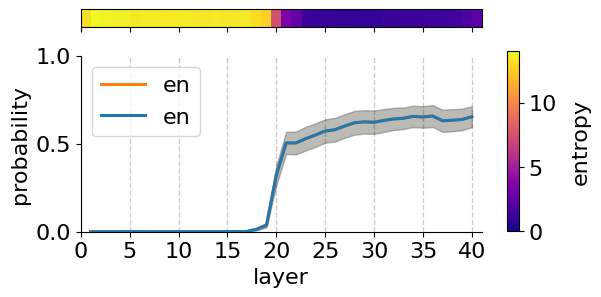

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

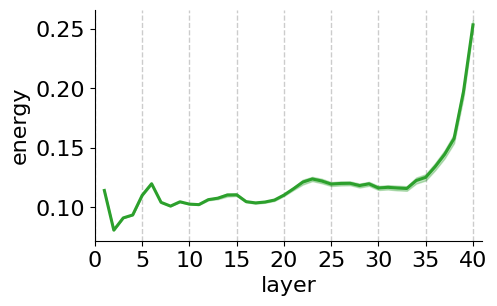

In [18]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')